In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cvx.covariance.ewma import iterated_ewma, _ewma_mean
from cvx.covariance.combination import from_sigmas
from experiments.utils.experiment_utils import add_to_diagonal, log_likelihood, ecdf

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
log_likelihoods = {}

for i, predictor in enumerate(cov_predictors):
    mean_predictor = mean_predictors[i]
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]
    # mus_temp = np.stack([mean_predictor.loc[t].values for t in
    # mean_predictor.keys()])[:-1]
    mus_temp = mean_predictor.loc[times].values
    if names[i] != 'CM-IEWMA':
        mus_temp = np.zeros(mus_temp.shape)
    else:
        print("works")

    

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp, means=mus_temp), index=times)

# regrets = {}
# for name in log_likelihoods:
#     regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing EWMA-10 log-likelihood...
Computing EWMA-21 log-likelihood...
Computing EWMA-63 log-likelihood...
Computing EWMA-125 log-likelihood...
Computing EWMA-250 log-likelihood...
Computing CM-IEWMA log-likelihood...
works


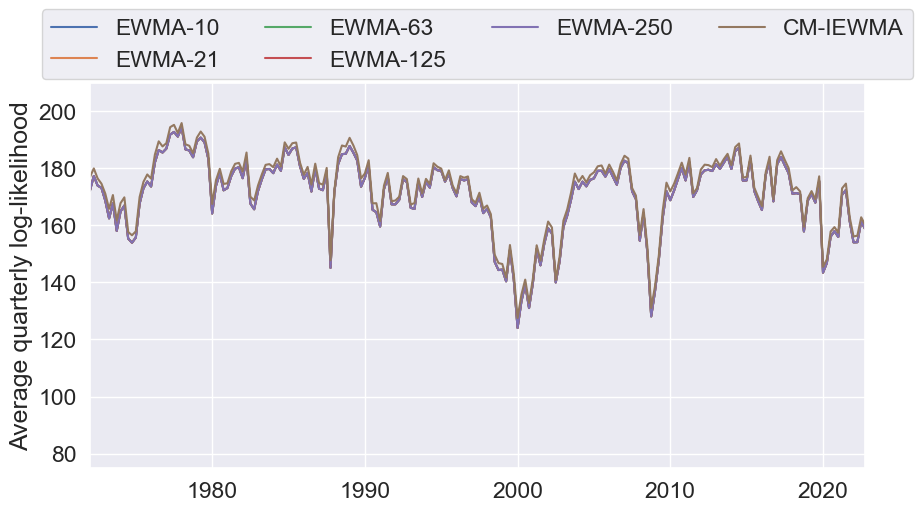

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly log-likelihood")
plt.ylim(75,210);

In [133]:
returns = pd.read_csv('../data/49_industries.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [3]:
### No mean adjustment
cm_iewma_pairs = [(21, 63), (63, 125), (125, 250), (250, 500), (500, 1000)]

# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results_no_mean = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

In [4]:
### With mean adjustment
cov_pairs = [(21, 63), (63, 125), (125, 250), (250, 500), (500, 1000)]
mean_pairs = [(21, 21), (63, 63), (125, 125), (250, 250), (500, 500)]


# CM-IEWMA
iewmas = {i: list(iterated_ewma(returns, vola_halflife=cov_pairs[i][0], cov_halflife=cov_pairs[i][1], min_periods_vola=63, min_periods_cov=63, mean=True, mu_halflife1=mean_pairs[i][0], mu_halflife2=mean_pairs[i][1])) for i in range(5)}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
mus = {key: {item.time: item.mean for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast =0
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results_with_mean = list(from_sigmas(Sigmas, returns, means=mus).solve(window=10))

In [5]:
covariance_no_mean = {result.time: result.covariance for result in results_no_mean}
weights_no_mean = {result.time: result.weights for result in results_no_mean}

covariance_with_mean = {result.time: result.covariance for result in results_with_mean}
weights_with_mean = {result.time: result.weights for result in results_with_mean}

cm_iewma_mean = pd.DataFrame({result.time: result.mean for result in results_with_mean}).T

In [6]:
# start_date = pd.to_datetime("1971-06-24", format="%Y-%m-%d")
start_date = cm_iewma_mean.index[0]
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

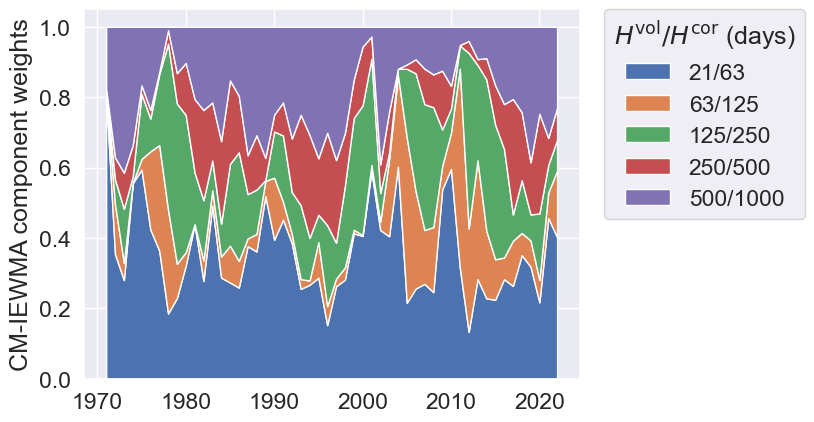

In [7]:
yearly_weights  = pd.DataFrame(weights_no_mean).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

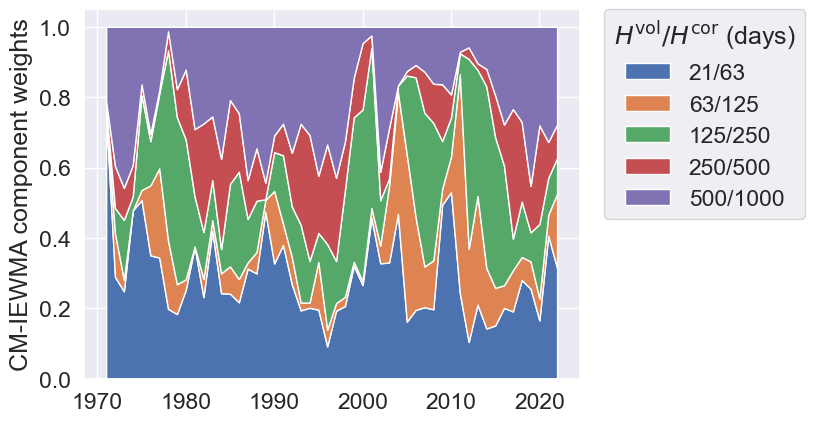

In [9]:
yearly_weights  = pd.DataFrame(weights_with_mean).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

# Mean variance portfolio

In [115]:
mean_pairs = [(10, 10), (21, 21), (63, 63), (125, 125), (250, 250)]

# r_hat_ewma10 = pd.DataFrame(dict(_ewma_mean(returns, halflife=10))).T
r_hat_ewma21 = pd.DataFrame(dict(_ewma_mean(returns, halflife=21))).T
r_hat_ewma63 = pd.DataFrame(dict(_ewma_mean(returns, halflife=63))).T
r_hat_ewma125 = pd.DataFrame(dict(_ewma_mean(returns, halflife=125))).T
r_hat_ewma250 = pd.DataFrame(dict(_ewma_mean(returns, halflife=250))).T
r_hat_ewma500 = pd.DataFrame(dict(_ewma_mean(returns, halflife=500))).T


mean_predictors = [r_hat_ewma21, r_hat_ewma63, r_hat_ewma125, r_hat_ewma250, r_hat_ewma500, cm_iewma_mean]
cov_predictors = [covariance_no_mean, covariance_no_mean, covariance_no_mean, covariance_no_mean, covariance_no_mean, covariance_with_mean]

In [12]:
from experiments.utils.portfolio_backtests import MeanVariance
sigma_tar = 0.05
names = ["EWMA-21", "EWMA-63", "EWMA-125", "EWMA-250", "EWMA-500", "CM-IEWMA"]
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}

traders_mean_var = MeanVariance(returns, cov_predictors[-2:], names, mean_predictors=mean_predictors[-2:], start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 2/2 [04:46<00:00, 143.47s/it]


In [130]:
len([*cov_predictors[0].keys()])

13382

In [129]:
mean_predictors[-1].index.shape

(13382,)

In [141]:
start_date = mean_predictors[-1].index[0]
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")
traders_mean_var_temp = MeanVariance(returns, [cov_predictors[0]], names, mean_predictors=[mean_predictors[-1]], start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 1/1 [05:13<00:00, 313.50s/it]


In [142]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_mean_var_temp, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-21 & 10.1\% & 6.0\% & 1.7 & 18\% \\
   \hline
   \bottomrule
\end{tabular}


In [13]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-21 & 5.1\% & 5.7\% & 0.9 & 18\% \\
   EWMA-63 & 10.8\% & 6.6\% & 1.6 & 19\% \\
   \hline
   \bottomrule
\end{tabular}


In [33]:
from experiments.utils.portfolio_backtests import MeanVariance
sigma_tar = 0.05
names = ["EWMA-10", "EWMA-21", "EWMA-63", "EWMA-125", "EWMA-250", "CM-IEWMA"]
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}

traders_mean_var = MeanVariance(returns, cov_predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

 67%|██████▋   | 4/6 [11:08<06:00, 180.30s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:209: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(
 83%|████████▎ | 5/6 [14:48<03:14, 194.46s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:209: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(
100%|██████████| 6/6 [19:40<00:00, 196.82s/it]


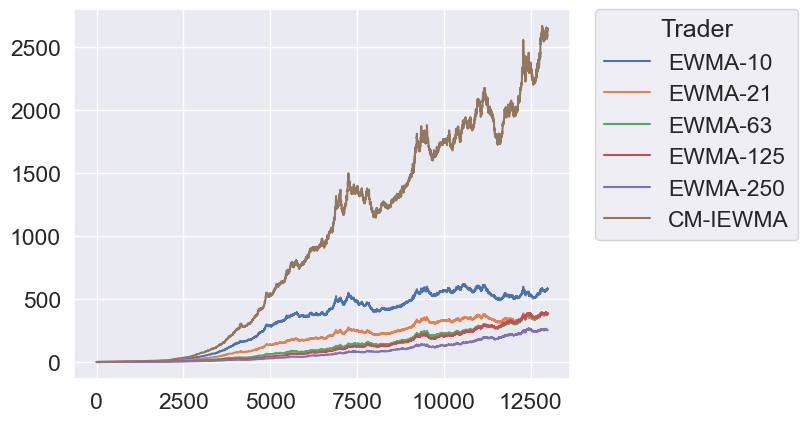

In [96]:
all_Vs = np.array([traders_mean_var[trader].Vs for trader in traders_mean_var]).reshape(-1,6)
all_Vs = pd.DataFrame(all_Vs, columns=names)

for trader in traders_mean_var:
    plt.plot(traders_mean_var[trader].Vs, label=trader)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Trader");

In [39]:
from experiments.utils.portfolio_backtests import create_table

rf = rf_rate.loc[start_date:end_date].iloc[:-1]
excess = True
create_table(traders_mean_var, None, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   EWMA-10 & 8.3\% & 6.0\% & 1.4 & 28\% \\
   EWMA-21 & 7.5\% & 6.1\% & 1.2 & 22\% \\
   EWMA-63 & 7.4\% & 6.2\% & 1.2 & 16\% \\
   EWMA-125 & 7.5\% & 6.1\% & 1.2 & 18\% \\
   EWMA-250 & 6.7\% & 6.0\% & 1.1 & 20\% \\
   CM-IEWMA & 11.2\% & 6.7\% & 1.7 & 24\% \\
   \hline


KeyError: 'PRESCIENT'

In [30]:
pairs = [(21, 63), (63, 125), (125, 250), (250, 500), (500, 1000)]

# compute the covariance matrices, one time series for each pair
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], clip_at=10000, min_periods_vola=63, min_periods_cov=63, mean=True)) for pair in pairs}
means = {key: {item.time: item.mean for item in iewma} for key, iewma in iewmas.items()}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

Sigmas["10-21"] = add_to_diagonal(Sigmas["10-21"], lamda=0.05)

In [31]:
combinator = CovarianceCombination(Sigmas=Sigmas, returns=returns, means=means)
results = list(combinator.solve_window(window=10, verbose=True))

100%|██████████| 3138/3138 [00:34<00:00, 90.08it/s] 


In [32]:
from collections import namedtuple

pred = namedtuple("pred", ["time", "mean", "covariance", "weights"])

cm_iewma_mean = {result.time: result.mean for result in results}
cm_iewma_cov = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}
times = [result.time for result in results]

cm_iewma = pred(times, cm_iewma_mean, cm_iewma_cov, weights)

In [33]:
# Prescient 
covs = {}
means = {}
times = []
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].mean().values
    covs[t] = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)
    means[t] = pd.Series(mean, index=returns.columns)
    times.append(t)
prescient = pred(times, means, covs, None)

# Quarterly Fama-French factors

In [103]:
returns = pd.read_csv('../data/ff5_no_rf.csv', index_col=0, parse_dates=True)
print("Average daily returns: ", returns.mean())
# Get quarterly returns
returns = returns.resample('Q').apply(lambda x: (x + 1).prod() - 1)
print("Average quarterly returns: ", returns.mean())

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

rf_rate = rf_rate.resample('Q').apply(lambda x: (x + 1).prod() - 1)

Average daily returns:  Mkt-RF    0.000265
SMB       0.000075
HML       0.000154
RMW       0.000138
CMA       0.000141
dtype: float64
Average quarterly returns:  Mkt-RF    0.017176
SMB       0.005354
HML       0.010480
RMW       0.009087
CMA       0.009284
dtype: float64


In [78]:
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63)]

# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=1, min_periods_cov=6)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

cm_iewma_ff_no_mean = {result.time: result.covariance for result in results}
weights_ff_no_mean = {result.time: result.weights for result in results}

In [79]:
### With mean adjustment
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63)]
mean_pairs = [(5, 5), (10, 10), (21, 21)]
K = len(mean_pairs)

# CM-IEWMA
iewmas = {i: list(iterated_ewma(returns, vola_halflife=cov_pairs[i][0], cov_halflife=cov_pairs[i][1], min_periods_vola=1, min_periods_cov=6, mean=True, mu_halflife1=mean_pairs[i][0], mu_halflife2=mean_pairs[i][1])) for i in range(K)}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
mus = {key: {item.time: item.mean for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast =0
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results_with_mean = list(from_sigmas(Sigmas, returns, means=mus).solve(window=10))

cm_iewma_ff_with_mean = {result.time: result.covariance for result in results_with_mean}
means = pd.DataFrame({result.time: result.mean for result in results_with_mean}).T
weights_ff_with_mean = {result.time: result.weights for result in results_with_mean}

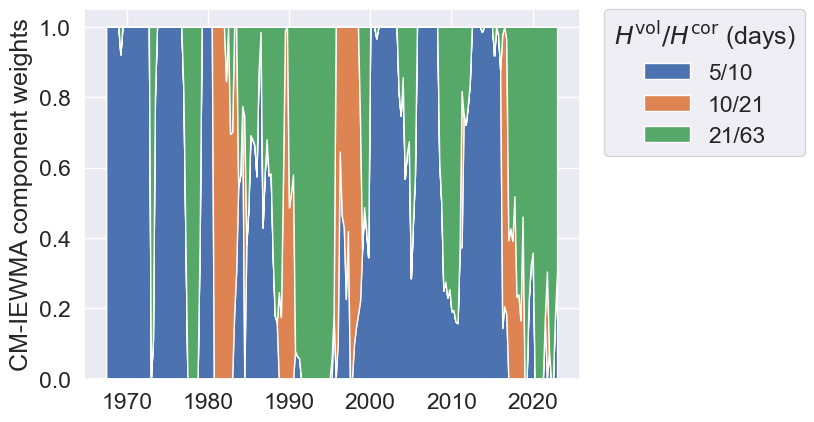

In [80]:
yearly_weights  = pd.DataFrame(weights_ff_no_mean).T

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

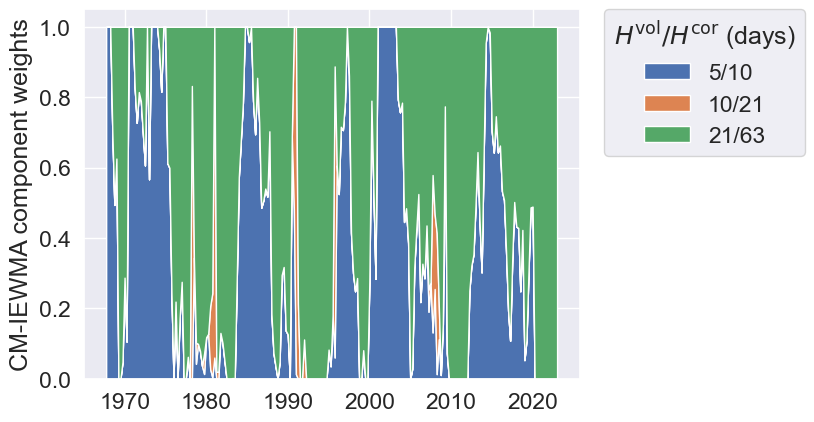

In [81]:
yearly_weights  = pd.DataFrame(weights_ff_with_mean).T

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

In [41]:
from experiments.utils.experiment_utils import log_likelihood_regularized


In [82]:
ll_no_mean = log_likelihood_regularized(returns, cm_iewma_ff_no_mean, r=None)


In [83]:
ll_with_mean = log_likelihood_regularized(returns, cm_iewma_ff_with_mean, r=None, means=means)

In [84]:
ll_no_mean.mean()

7.836514927289941

In [85]:
ll_with_mean.mean()

7.175618417652285

(-10.0, 15.0)

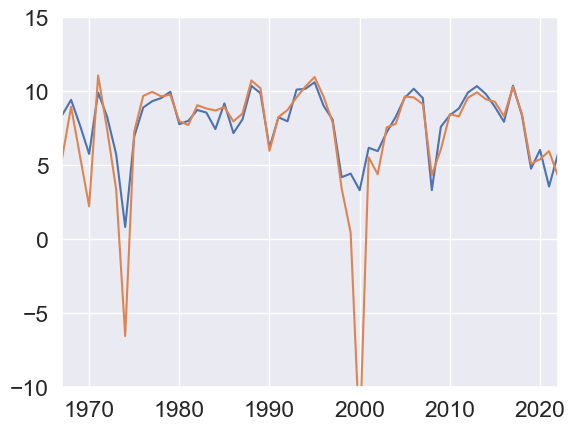

In [86]:
ll_no_mean.resample("Y").mean().plot()
ll_with_mean.resample("Y").mean().plot()
plt.ylim(-10,15)

# Portfolios

In [109]:
from experiments.utils.portfolio_backtests import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.4,\
             "lower_bound":-0.3}

# Volatility target
sigma_tar = 0.02
excess = False

In [110]:
names = ["No mean", "With mean"]
predictors = [cm_iewma_ff_no_mean, cm_iewma_ff_with_mean]
start_date = [*cm_iewma_ff_with_mean.keys()][0]
end_date = [*cm_iewma_ff_with_mean.keys()][-1]
traders_min_risk = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


In [101]:
names

['EWMA-21', 'EWMA-63', 'EWMA-125', 'EWMA-250', 'EWMA-500', 'CM-IEWMA']

In [100]:
traders_min_risk

{'EWMA-21': <experiments.utils.trading_model.Trader at 0x7fb70f1f3d30>,
 'EWMA-63': <experiments.utils.trading_model.Trader at 0x7fb70f29ac70>}

In [111]:
create_table(traders_min_risk, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   No mean & 268.0\% & 12.4\% & 21.7 & 1\% \\
   With mean & 270.7\% & 12.5\% & 21.6 & 0\% \\
   \hline
   \bottomrule
\end{tabular}
